In [1]:
pip install cython pycocotools

In [2]:
from torch import nn
from collections import OrderedDict
from google.colab import drive
drive.mount('/content/drive')

class SSDBackbone(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        layer0 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu)
        layer1 = backbone.layer1
        layer2 = backbone.layer2
        layer3 = backbone.layer3
        layer4 = backbone.layer4

        self.features = nn.Sequential(layer0, layer1, layer2, layer3) #6464
        self.upsampling= nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1),
            nn.ReLU(inplace=True),
        )
        self.extra = nn.ModuleList(
            [
                nn.Sequential(
                    layer4,
                    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),
                    nn.ReLU(inplace=True),
                ), #32*32
                nn.Sequential(
                    nn.Conv2d(1024, 256, kernel_size=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=2),
                    nn.ReLU(inplace=True),
                ), #16*16
                nn.Sequential(
                    nn.Conv2d(512, 128, kernel_size=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2),
                    nn.ReLU(inplace=True),
                ), #8*8
                nn.Sequential(
                    nn.Conv2d(256, 128, kernel_size=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(128, 256, kernel_size=3),
                    nn.ReLU(inplace=True),
                ), #6*6
                nn.Sequential(
                    nn.Conv2d(256, 128, kernel_size=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(128, 256, kernel_size=3),
                    nn.ReLU(inplace=True),
                ), #4*4
                nn.Sequential(
                    nn.Conv2d(256, 128, kernel_size=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(128, 256, kernel_size=4),
                    nn.ReLU(inplace=True),
                ) #1*1
            ]
        )


    def forward(self, x):
        x = self.features(x)
        output = [self.upsampling(x)]

        for block in self.extra:
            x = block(x)
            output.append(x)

        return OrderedDict([(str(i), v) for i, v in enumerate(output)])

Mounted at /content/drive


In [3]:
import torch
from torchvision.models import resnet34
from torchvision.models.detection import ssd
from torchvision.models.detection.anchor_utils import DefaultBoxGenerator


backbone_base = resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")
backbone = SSDBackbone(backbone_base)
anchor_generator = DefaultBoxGenerator(
    aspect_ratios=[[2], [2, 3], [2, 3], [2, 3], [2, 3], [2], [2]],
    scales=[0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05, 1.20],
    steps=[8, 16, 32, 64, 100, 300, 512],
)
#SSD default box generator implementation
#https://github.com/yeomko22/ssd_defaultbox_generator/blob/master/ssd_defaultbox_generator.ipynb
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ssd.SSD(
    backbone=backbone,
    anchor_generator=anchor_generator,
    size=(512, 512),
    num_classes=3
).to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 149MB/s]


In [5]:
import os
import torch
from PIL import Image
from pycocotools.coco import COCO
from torch.utils.data import Dataset

#이하 Faster R-CNN에서와 동일

class COCODataset(Dataset):
    def __init__(self, root, train, transform=None):
        super().__init__()
        directory = "train" if train else "val"
        annotations = os.path.join(root, "annotations", f"{directory}_annotations.json")

        self.coco = COCO(annotations)
        self.iamge_path = os.path.join(root, directory)
        self.transform = transform

        self.categories = self._get_categories()
        self.data = self._load_data()

    def _get_categories(self):
        categories = {0: "background"}
        for category in self.coco.cats.values():
            categories[category["id"]] = category["name"]
        return categories

    def _load_data(self):
        data = []
        for _id in self.coco.imgs:
            file_name = self.coco.loadImgs(_id)[0]["file_name"]
            image_path = os.path.join(self.iamge_path, file_name)
            image = Image.open(image_path).convert("RGB")

            boxes = []
            labels = []
            anns = self.coco.loadAnns(self.coco.getAnnIds(_id))
            for ann in anns:
                x, y, w, h = ann["bbox"]

                boxes.append([x, y, x + w, y + h])
                labels.append(ann["category_id"])

            target = {
            "image_id": torch.LongTensor([_id]),
                "boxes": torch.FloatTensor(boxes),
                "labels": torch.LongTensor(labels)
            }
            data.append([image, target])
        return data

    def __getitem__(self, index):
        image, target = self.data[index]
        if self.transform:
            image = self.transform(image)
        return image, target

    def __len__(self):
        return len(self.data)

In [6]:
from torchvision import transforms
from torch.utils.data import DataLoader


def collator(batch):
    return tuple(zip(*batch))

transform = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(dtype=torch.float)
    ]
)

train_dataset = COCODataset("/content/drive/MyDrive/datasets/coco", train=True, transform=transform)
test_dataset = COCODataset("/content/drive/MyDrive/datasets/coco", train=False, transform=transform)

train_dataloader = DataLoader(
    train_dataset, batch_size=4, shuffle=True, drop_last=True, collate_fn=collator
)
test_dataloader = DataLoader(
    test_dataset, batch_size=1, shuffle=True, drop_last=True, collate_fn=collator
)

loading annotations into memory...
Done (t=1.52s)
creating index...
index created!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


In [7]:
from torch import optim


params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [8]:
for epoch in range(10):
    cost = 0.0
    for idx, (images, targets) in enumerate(train_dataloader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        cost += losses

    lr_scheduler.step()
    cost = cost / len(train_dataloader)
    print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")

Epoch :    1, Cost : 6.295
Epoch :    2, Cost : 5.344
Epoch :    3, Cost : 4.860
Epoch :    4, Cost : 4.464
Epoch :    5, Cost : 4.134
Epoch :    6, Cost : 3.582
Epoch :    7, Cost : 3.383
Epoch :    8, Cost : 3.262
Epoch :    9, Cost : 3.156
Epoch :   10, Cost : 3.045


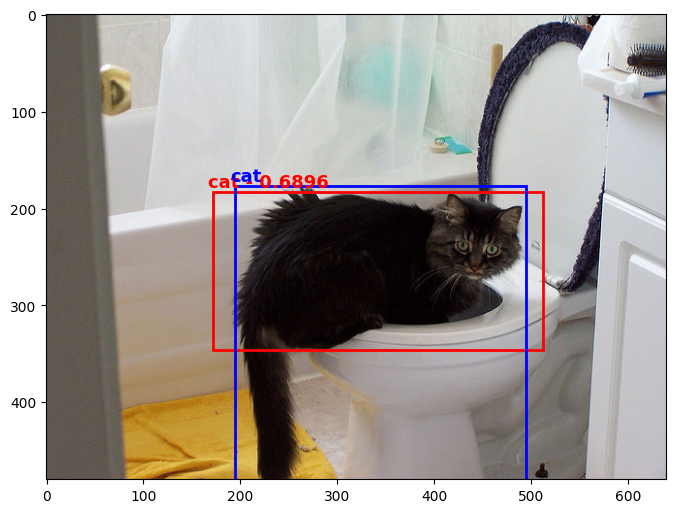

In [12]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image


def draw_bbox(ax, box, text, color):
    ax.add_patch(
        plt.Rectangle(
            xy=(box[0], box[1]),
            width=box[2] - box[0],
            height=box[3] - box[1],
            fill=False,
            edgecolor=color,
            linewidth=2,
        )
    )
    ax.annotate(
        text=text,
        xy=(box[0] - 5, box[1] - 5),
        color=color,
        weight="bold",
        fontsize=13,
    )

threshold = 0.5
categories = test_dataset.categories
with torch.no_grad():
    model.eval()
    for images, targets in test_dataloader:
        images = [image.to(device) for image in images]
        outputs = model(images)

        boxes = outputs[0]["boxes"].to("cpu").numpy()
        labels = outputs[0]["labels"].to("cpu").numpy()
        scores = outputs[0]["scores"].to("cpu").numpy()

        boxes = boxes[scores >= threshold].astype(np.int32)
        labels = labels[scores >= threshold]
        scores = scores[scores >= threshold]

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(1, 1, 1)
        plt.imshow(to_pil_image(images[0]))

        for box, label, score in zip(boxes, labels, scores):
            draw_bbox(ax, box, f"{categories[label]} - {score:.4f}", "red")

        tboxes = targets[0]["boxes"].numpy()
        tlabels = targets[0]["labels"].numpy()
        for box, label in zip(tboxes, tlabels):
            draw_bbox(ax, box, f"{categories[label]}", "blue")
        break

        plt.show()

In [ ]:
import numpy as np
from pycocotools.cocoeval import COCOeval


with torch.no_grad():
    model.eval()
    coco_detections = []
    for images, targets in test_dataloader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i in range(len(targets)):
            image_id = targets[i]["image_id"].data.cpu().numpy().tolist()[0]
            boxes = outputs[i]["boxes"].data.cpu().numpy()
            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
            scores = outputs[i]["scores"].data.cpu().numpy()
            labels = outputs[i]["labels"].data.cpu().numpy()

            for instance_id in range(len(boxes)):
                box = boxes[instance_id, :].tolist()
                prediction = np.array(
                    [
                        image_id,
                        box[0],
                        box[1],
                        box[2],
                        box[3],
                        float(scores[instance_id]),
                        int(labels[instance_id]),
                    ]
                )
                coco_detections.append(prediction)
    coco_detections = np.asarray(coco_detections)

    coco_gt = test_dataloader.dataset.coco
    coco_dt = coco_gt.loadRes(coco_detections)
    coco_evaluator = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_evaluator.evaluate()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()

In [ ]:
def retrieve_out_channels(model, size):
    model.eval()
    with torch.no_grad():
        device = next(model.parameters()).device
        image = torch.zeros((1, 3, size[1], size[0]), device=device)
        features = model(image)

        if isinstance(features, torch.Tensor):
            features = OrderedDict([("0", features)])
        out_channels = [x.size(1) for x in features.values()]

    model.train()
    return out_channels

print(retrieve_out_channels(backbone, (512, 512)))

In [15]:
anchor_generator.min_ratio

AttributeError: 'DefaultBoxGenerator' object has no attribute 'min_ratio'